In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.model_selection import train_test_split
from joblib import dump, load
# 사전 라이브러리 설치(XAI용, XAI: 실현가능한 AI) : pip install shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [8]:
# 1. 데이터 로드 및 캐싱
@st.cache_data
def load_data():
    df = pd.read_csv('dataset/mental_health_wearable_data.csv', encoding='utf-8')
    df = df.rename(columns={'Mental_Health_Condition ': 'Mental_Health_Condition'})
    return df


df = load_data()
df.columns = df.columns.str.strip()
print(df.columns)

2025-03-25 12:40:00.086 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-25 12:40:00.088 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-25 12:40:00.089 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 12:40:00.424 
  command:

    streamlit run c:\Python310\aiproject\dl_Study\.venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-25 12:40:00.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 12:40:00.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 12:40:00.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 12:40:00.436 Thread 'MainTh

Index(['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Physical_Activity_Steps',
       'Mood_Rating', 'Mental_Health_Condition'],
      dtype='object')


In [9]:
df.head()

,Heart_Rate_BPM,Sleep_Duration_Hours,Physical_Activity_Steps,Mood_Rating,Mental_Health_Condition
0,98,7.43,13760,5,1
1,111,9.46,11455,9,0
2,88,4.04,9174,8,1
3,74,8.86,12612,1,1
4,102,9.69,3923,9,0


In [10]:
# 결측치 확인
print("데이터 결측치 확인:")
print(df.isnull().sum())

데이터 결측치 확인:
Heart_Rate_BPM             0
Sleep_Duration_Hours       0
Physical_Activity_Steps    0
Mood_Rating                0
Mental_Health_Condition    0
dtype: int64


In [11]:
# 불필요한 컬럼 제거 (원핫 인코딩 없이도 잘 작동하도록)
df = df.drop(['Physical_Activity_Steps', 'Mood_Rating'], axis=1)

In [12]:
# 전처리 후 데이터 확인
print("전처리 후 데이터 형태:")
print("데이터:", df.shape)

전처리 후 데이터 형태:
데이터: (10000, 3)


In [13]:
# 데이터 컬럼 확인
print("\n데이터 컬럼:", df.columns.tolist())


데이터 컬럼: ['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Mental_Health_Condition']


In [14]:
# 스케일링 : 데이터 정규화 - (MinMaxScaler)
scaler = MinMaxScaler()
X = df.drop('Mental_Health_Condition', axis=1)
y = df['Mental_Health_Condition']

In [15]:
# 피처 수 확인
n_features = X.shape[1]
print(f"피처 수: {n_features}")

피처 수: 2


In [16]:
X = scaler.fit_transform(X)

In [17]:
# 특성 이름 저장 (SHAP 시각화에 사용)
feature_names = df.drop('Mental_Health_Condition', axis=1).columns.tolist()

In [18]:
# train, validation set 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Set (학습 데이터) : 모델을 학습시키는 데 사용
# Validation Set (검증 데이터) : 학습된 모델을 평가하고, 하이퍼파라미터 튜닝에 사용
# Test Set (테스트 데이터) : 최종 모델의 성능을 확인하는 데 사용 (실제 예측에 가까움)
# 모델이 과적합하지 않도록 검증 데이터(Validation Set)를 생성하는 과정
# Train Set에서 학습한 모델을 Validation Set에서 테스트해보면서 최적의 하이퍼파라미터를 찾고, 모델의 일반화 성능을 평가


In [19]:
# 데이터 형태 확인
print(f"X_train 형태(reshape 전): {X_train.shape}")
print(f"X_val 형태(reshape 전): {X_val.shape}")

X_train 형태(reshape 전): (8000, 2)
X_val 형태(reshape 전): (2000, 2)


In [20]:
# LSTM 입력을 위한 reshape (samples, time steps, features)
# LSTM 입력에 맞게 데이터 형태 변경
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_val = X_val.reshape(X_val.shape[0], 1, n_features)

In [21]:
# reshape 후 형태 확인
print(f"X_train 형태(reshape 후): {X_train.shape}")
print(f"X_val 형태(reshape 후): {X_val.shape}")

X_train 형태(reshape 후): (8000, 1, 2)
X_val 형태(reshape 후): (2000, 1, 2)


In [22]:
# 2. LSTM 모델 구축(생성)
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # 정신건강이 좋을 가능성에 대한 이진 분류(1, 0)이므로 sigmoid 사용

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # binary_crossentropy : 이진 분류에 사용 (ex. 0, 1 등)

c:\Python310\aiproject\dl_Study\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Early Stopping - verbose=1로 설정하여 진행상황 확인
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # 10번의 에폭 동안 개선이 없으면 학습 중단
    restore_best_weights=True,    #  가장 좋은 성능을 보였던 모델의 가중치(weights)를 복원
    verbose=1             # 중단 시 메시지 출력
)

In [26]:
# 3. 모델 훈련 - verbose=1로 설정하여 진행상황 확인
epochs = 100
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1             # 훈련 진행상황 출력
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6038 - loss: 0.2437 - val_accuracy: 0.6720 - val_loss: 0.2102
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.2109 - val_accuracy: 0.6735 - val_loss: 0.2091
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6559 - loss: 0.2098 - val_accuracy: 0.6690 - val_loss: 0.2084
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.2078 - val_accuracy: 0.6710 - val_loss: 0.2084
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.2059 - val_accuracy: 0.6715 - val_loss: 0.2079
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6758 - loss: 0.2058 - val_accuracy: 0.6715 - val_loss: 0.2083
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 0.2089 - val_accuracy: 0.6705 - val_loss: 0.2079
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6690 - loss: 0.2076 - val_accu

In [27]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print(f"학습이 {actual_epochs}번째 에폭에서 완료되었습니다.")

학습이 20번째 에폭에서 완료되었습니다.


In [28]:
# 4. 예측 및 평가
# Validation set 평가
y_pred_val_proba = model.predict(X_val, verbose=0)

y_pred_val = (y_pred_val_proba > 0.5).astype(int)    # 0.5를 기준으로 분류, astype(int) : True는 1로, False는 0

In [29]:
# ROC Curve 및 AUC 계산 (Validation set)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

In [30]:
# Confusion Matrix (Validation set)
cm = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation Set):\n", cm)

Confusion Matrix (Validation Set):
 [[627 345]
 [311 717]]


In [31]:
# Classification Report (Validation set)
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_pred_val))


Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.67      0.65      0.66       972
           1       0.68      0.70      0.69      1028

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



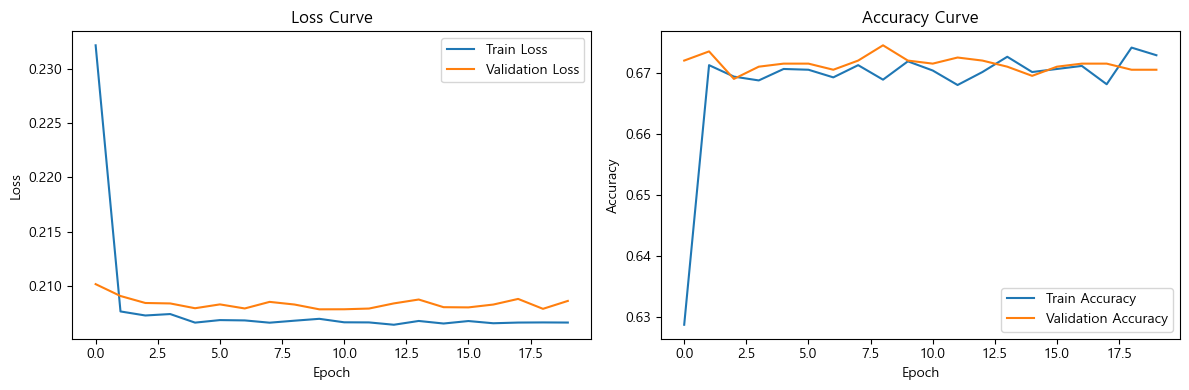

In [32]:
# 5. 결과 시각화 및 통계 분석
# 학습 곡선(과정) 시각화 (loss, accuracy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

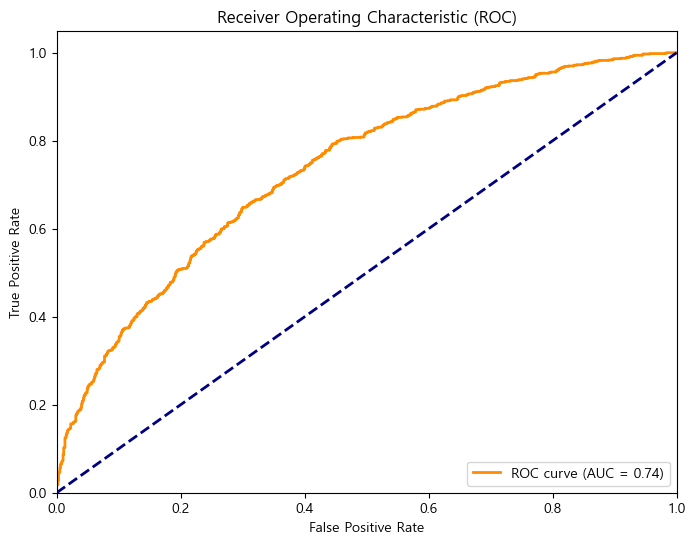

In [33]:
# ROC Curve 시각화 (Validation set)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

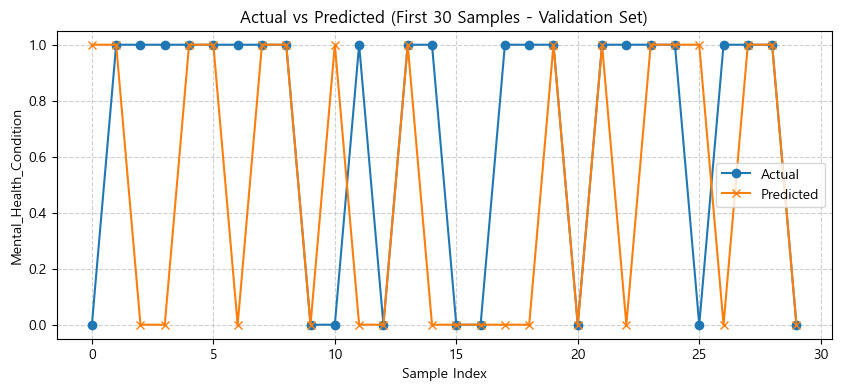

In [34]:
# 실제값 vs 예측값 시각화 (Validation set - 처음 30개 샘플)
plt.figure(figsize=(10, 4))
plt.plot(y_val[:30].values, label='Actual', marker='o')
plt.plot(y_pred_val[:30].flatten(), label='Predicted', marker='x')  # flatten() 추가
plt.title('Actual vs Predicted (First 30 Samples - Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Mental_Health_Condition')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
plt.show()

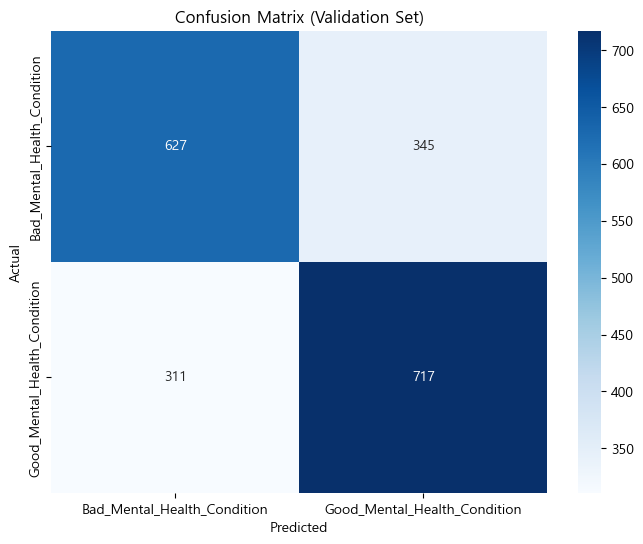

In [35]:
# Confusion Matrix 시각화 (Validation set)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad_Mental_Health_Condition', 'Good_Mental_Health_Condition'], yticklabels=['Bad_Mental_Health_Condition', 'Good_Mental_Health_Condition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()
# 🔍 혼동행렬 분석 (내가 출력한 그래프 의미 해석)
# 1️⃣ 총 2000개의 검증 데이터 중 모델이 1339건을 정확히 예측함 (633 + 706).
# 2️⃣ 633건은 실제로 "Bad Mental Health"이고, 모델도 정확히 "Bad"라고 예측 (TN).
# 3️⃣ 706건은 실제로 "Good Mental Health"이고, 모델도 정확히 "Good"이라고 예측 (TP).
# 4️⃣ 339건은 실제로 "Bad Mental Health"인데, 모델이 "Good Mental Health"로 잘못 예측 (FP, 거짓 양성).
# 5️⃣ 322건은 실제로 "Good Mental Health"인데, 모델이 "Bad Mental Health"로 잘못 예측 (FN, 거짓 음성).

# ✔ 모델이 전체적으로 어느 정도 정확하게 작동하지만, FP와 FN이 존재하여 개선이 필요함! 

C:\Users\yj\AppData\Local\Temp\ipykernel_11900\1744047028.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Mental_Health_Condition', data=df, palette='viridis')


Text(0, 0.5, '인원 수')

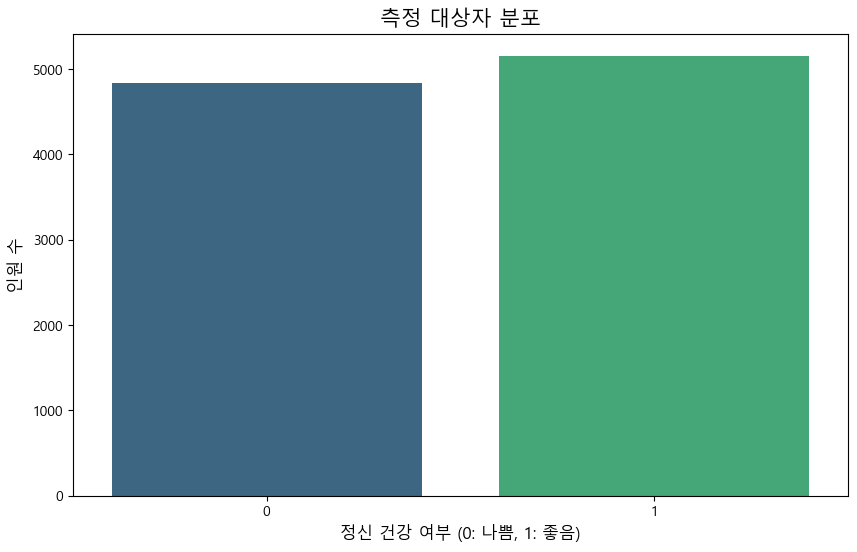

In [ ]:
# 정신건강 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Mental_Health_Condition', data=df, palette='viridis')
plt.title('측정 대상자 분포', fontsize=15)
plt.xlabel('정신 건강 여부 (0: 나쁨, 1: 좋음)', fontsize=12)
plt.ylabel('인원 수', fontsize=12)

In [ ]:
# 모델 저장 (선택 사항)
model.save('model/rnn_LSTM_pred_mentalHealth.h5')
print("모델이 'trnn_LSTM_pred_mentalHealth.h5' 파일로 저장되었습니다.")